In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path
from psutil import cpu_count

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

import tensorboardX

from freesound.utils.general import seed_everything, setup_tboard_writer
from freesound.utils.lwlwrap import calculate_per_class_lwlrap
from freesound.spec_augment import augment_spectrogram as augspecorig
from freesound.imaug_seqs import imgaug_seqs_dict
from freesound.archis.large import Classifier

import bz2
from freesound.preprocessor import Preprocessor
import pylab as plt
from pathlib import Path
import os

from shutil import rmtree
import json
from freesound.utils.general import hash_dict

In [3]:
def read_folder_of_dfs(dfs_path):
    df = None
    for f in os.listdir(str(dfs_path)):
        if f.endswith('.csv'):
            this = pd.read_hdf(dfs_path / f, 'data')
            if df is None:
                df = this
            else:
                df = pd.concat([df, this], 0)
    return df

hashes = ['41382d5c471d50a6', 'e14eb8b559752c4e', 'fb20c327c59f874c']
dfs_paths = [Path('ckpts') / i for i in hashes]

In [4]:
df = pd.concat([read_folder_of_dfs(dfs_path) for dfs_path in dfs_paths], 0)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

## PARAMS ##
SEED = 2019
NUM_VAL_PREDS_PER_EPOCH = 48
PREPROCESSOR_CONFIG_NAME = 'tf_2048'
RANDOM_VOLUME = 0.8
SPEC_AUGMENT_PROB = 0.25
MIXUP_ALPHA = 0.0
IMGAUG_SEQ = 'default'
BATCH_SIZE = 64
LR = 3e-3
LR_MIN = 1e-5
T_MAX = 10
NUM_EPOCHS = 301
############

preprocessor_config_path = 'config/preprocessing/{}.yaml'.format(PREPROCESSOR_CONFIG_NAME)
augment_spectrogram = lambda x: augspecorig(x, RANDOM_VOLUME, SPEC_AUGMENT_PROB)

In [6]:
# Hash params config and write to file
params_dict = {}
params_str = ['NUM_VAL_PREDS_PER_EPOCH', 'SEED', 'PREPROCESSOR_CONFIG_NAME', 'RANDOM_VOLUME', 'SPEC_AUGMENT_PROB',
              'MIXUP_ALPHA', 'IMGAUG_SEQ', 'BATCH_SIZE', 'LR', 'LR_MIN', 'T_MAX', 'NUM_EPOCHS']
for k in params_str:
    params_dict[k] = eval(k)
params_hash = hash_dict(params_dict)

savedir = Path('ckpts') / 'student' / params_hash
os.makedirs(savedir)
with open(savedir / 'config.json', 'w') as f:
    json.dump(params_dict, f)

In [7]:
seed_everything(SEED)
tboard_writer, tboard_log_dir = setup_tboard_writer('student_' + params_hash)

In [8]:
N_JOBS = cpu_count()
os.environ['MKL_NUM_THREADS'] = str(N_JOBS)
os.environ['OMP_NUM_THREADS'] = str(N_JOBS)
DataLoader = partial(DataLoader, num_workers=N_JOBS)

In [9]:
dataset_dir = Path(os.environ['FS_INPUTS_BASE']) / 'freesound-audio-tagging-2019'

In [10]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    'train_noisy': dataset_dir / 'train_noisy.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
    'test': dataset_dir / 'test.csv',
}

In [11]:
csvs['sample_submission']

PosixPath('/media/hd1/Liam/fs/input/freesound-audio-tagging-2019/sample_submission.csv')

In [12]:
df_train_curated = pd.read_csv(csvs['train_curated'])
df_train_noisy = pd.read_csv(csvs['train_noisy'])

In [13]:
num_classes = 80

In [14]:
def df_to_dummies(df):
    y_train = df['labels'].str.get_dummies(sep=',').values.astype(np.float32)
    assert y_train.shape[1] == 80
    return y_train

def df_to_x(df):
    return df.fname.values

def df_to_xy(df):
    y = df_to_dummies(df)
    x = df_to_x(df)
    assert len(x) == len(y)
    return x, y

In [15]:
x_train, y_train = df_to_xy(df_train_curated)
x_train_noisy, y_train_noisy = df_to_xy(df_train_noisy)
x_train_all = np.concatenate([x_train, x_train_noisy], 0)
y_train_all = np.concatenate([y_train, y_train_noisy], 0)
all_wavnames = np.append(x_train, x_train_noisy)

In [16]:
preproc = Preprocessor(preprocessor_config_path)
preproc.fill_cache(all_wavnames)

Loading took 276.2520124912262 seconds


In [17]:
seq = imgaug_seqs_dict[IMGAUG_SEQ]

In [18]:
def get_noisy_img_and_label(pp):
    idx = np.random.randint(len(x_train_noisy))
    fname = x_train_noisy[idx]
    return pp[fname], y_train_noisy[idx], fname
        

class FATTrainDataset(Dataset):
    def __init__(self, preproc, fnames, labels, seq, mixup_alpha=MIXUP_ALPHA, is_training=True,
                 desired_length=128, no_labels=False, no_fnames=True, do_augmentation=True, df=None):
        super().__init__()
        self.preproc = preproc
        self.fnames = fnames
        self.labels = labels
        self.seq = seq
        self.mixup_alpha = mixup_alpha
        self.is_training = is_training
        self.desired_length = desired_length
        self.no_labels = no_labels
        self.no_fnames = no_fnames

        self.transforms = transforms.ToTensor()
        self.no_fnames = no_fnames
        self.do_augmentation = do_augmentation
        self.df = df
        
        if df is None:
            epoch_len = len(fnames)
        else:
            epoch_len = len(df)
        self.epoch_len = epoch_len
        
    def __len__(self):
        return self.epoch_len
    
    def crop_img(self, image, crop=None):
        time_dim = image.shape[1]
        diff = time_dim - self.desired_length
        if diff > 0:
            if crop is None:
                crop = random.randint(0, diff)
            image = image[:, crop:crop + self.desired_length]
        elif diff < 0:
            tmp = np.zeros([image.shape[0], self.desired_length, *image.shape[2:]],
                           dtype=image.dtype)
            if crop is None:
                crop = random.randint(0, -diff)
            tmp[:, crop:crop + image.shape[1]] = image
            image = tmp
        else:
            crop = 0
        return image, crop
    
    def prep_img(self, image):
        if self.is_training and self.do_augmentation:
            image = self.seq.augment_image(image)
        image = self.transforms(image)
        if self.is_training and self.do_augmentation:
            image = augment_spectrogram(image)
        return image.div_(255)
    
    def preprep_img(self, image):
        if image.shape[0] == 1:
            image = np.tile(image, [3, 1, 1])
        image = np.transpose(image, [1, 2, 0])
        return image
    
    def _fix_crop(self, img):
        if img.shape != (128, 128, 3):
            out = np.zeros([128, 128, 3], dtype=img.dtype)
            out[:min(img.shape[0], 128), :min(img.shape[1], 128)] = img[:128, :128]
            return out
        return img
    
    def get_pd(self, idx):
        c0, c1, f0, f1, mixup_p, y = self.df.iloc[idx].values
        image = self.preproc[f0]
        image = self.preprep_img(image)
        image, crop = self.crop_img(image, c0)
        image = self._fix_crop(image)
        if mixup_p < 0.98:  # save compute when mixup barely has effect
            oth_image = self.preproc[f1]
            oth_image = self.preprep_img(oth_image)
            oth_image, oth_crop = self.crop_img(oth_image, c1)
            oth_image = self._fix_crop(oth_image)
            image = mixup_p * image + (1 - mixup_p) * oth_image
            image = image.round().astype(np.uint8)
        image = self.prep_img(image)
        return image, y
            
    def __getitem__(self, idx):
        if self.df is not None:
            return self.get_pd(idx)
        fname = self.fnames[idx]
        oth_fname = ''
        image = self.preproc[fname]
        image = self.preprep_img(image)
        if not self.no_labels:
            label = self.labels[idx]
        image, crop = self.crop_img(image)
        crops = [crop, -99999]
        mixup_p = 1.0
        if self.is_training and self.mixup_alpha:
            mixup_p = np.random.beta(self.mixup_alpha + 1, self.mixup_alpha)
            if mixup_p < 0.98:  # save compute when mixup barely has effect
                oth_image, oth_label, oth_fname = get_noisy_img_and_label(self.preproc)
                oth_image = self.preprep_img(oth_image)
                oth_image, oth_crop = self.crop_img(oth_image)
                crops[-1] = oth_crop
                image = mixup_p * image + (1 - mixup_p) * oth_image
                image = image.round().astype(np.uint8)
                label = label + (1 - mixup_p) * oth_label
                label = np.clip(label, 0.0, 1.0)
        image = self.prep_img(image)
        ret = []
        ret += [image]
        if self.no_labels:
            return tuple(ret)
        ret += [torch.from_numpy(label).float()]
        if self.no_fnames:
            return tuple(ret)
        ret += crops
        ret += [fname, oth_fname]
        ret += [mixup_p]
        return tuple(ret)

In [19]:
batch_size = BATCH_SIZE
test_batch_size = BATCH_SIZE * 2
lr = LR
lr_min = LR_MIN
t_max = T_MAX

In [20]:
train_dataset = FATTrainDataset(preproc, x_train, y_train, seq=seq, mixup_alpha=MIXUP_ALPHA, is_training=True, df=df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [21]:
valid_dataset = FATTrainDataset(preproc, x_train, y_train, seq=seq, mixup_alpha=MIXUP_ALPHA, is_training=False, df=df)

In [22]:
# x, y, c0, c1, f0, f1, mix = valid_dataset[0]
# df = [[c0, c1, f0, f1, mix, 'y']]
# test_ds = FATTrainDataset(preproc, x_train_all, y_train_all, seq=seq, is_training=True, do_augmentation=False, df=df)
# torch.all(test_ds[0][0] = x)  # True

In [23]:
import torch.nn.functional as F

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

model = Classifier(num_classes=num_classes)
model = model.cuda()
optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)
scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=lr_min)
student_loss = 'nll'
if student_loss == 'nll':
    criterion = nn.BCEWithLogitsLoss().cuda()
else:
    criterion = nn.MSELoss().cuda()
model = nn.DataParallel(model)

In [24]:
epoch = 0
global_step = 0
num_epochs = NUM_EPOCHS

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
sched_steps_per_epoch = len(df) / len(x_train)
next_sched_step = len(train_loader) / sched_steps_per_epoch

In [ ]:
quasi_epoch = 0

In [ ]:
def is_interesting_epoch(epoch):
    epoch = epoch + 1
    if epoch // 10 % 2 == 1:
        if epoch - (10 * (epoch // 10)) < 5:
            if epoch > 100:
                return True
    return False

mb = master_bar(range(epoch, num_epochs))

for epoch in mb:
    start_time = time.time()
    model.train()
    avg_loss = 0.
    count_this_avg = 0.

    for stuff in progress_bar(train_loader, parent=mb):
        global_step += 1

        if len(stuff) == 2:
            x_batch, y_batch = [i.cuda() for i in stuff]
            
        preds = model(x_batch)
        if student_loss == 'nll':
            y_batch = torch.sigmoid(y_batch)
        loss_train = criterion(preds, y_batch)
        loss = loss_train
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss_train.item()
        count_this_avg += 1
        
        if global_step >= next_sched_step:
            # Quasi end-of-epoch
            next_sched_step += len(train_loader) / sched_steps_per_epoch
            scheduler.step()
            
            elapsed = time.time() - start_time
            start_time = time.time()

            tboard_writer.add_scalar('metrics/avg_train_loss', avg_loss / count_this_avg, quasi_epoch + 1)
            tboard_writer.add_scalar('meta/lr', get_lr(optimizer), quasi_epoch + 1)
            tboard_writer.add_scalar('meta/elapsed', elapsed, quasi_epoch + 1)
            
            avg_loss = 0.
            count_this_avg = 0.
            
            if is_interesting_epoch(quasi_epoch):
                torch.save(model.module.state_dict(), Path(savedir) / 'weight_epoch{}.pt'.format(quasi_epoch + 1))
            
            quasi_epoch += 1

In [ ]:
ii = -1

In [ ]:
ii += 1
f = fs[(-cs).argsort()[ii]]
dff = df[df['f0']==f]
p = sigmoid(np.stack(dff[dff['mix']>0.8]['y'].values, 0))
print(len(p))
# for i in p:
#     plt.step(np.arange(i.shape[0]), i, alpha=0.2)
model.eval()
with torch.no_grad():
    x_pred = valid_dataset.prep_img(valid_dataset.crop_img(valid_dataset.preprep_img(preproc[f]))[0])    
    pred = torch.sigmoid(model(x_pred.unsqueeze(0).cuda())).cpu().numpy()[0]
plt.step(np.arange(i.shape[0]), p.mean(0), alpha=0.5)
plt.step(np.arange(len(pred)), pred, alpha=0.5)

In [ ]:
print([(labels[i], p.mean(0)[i]) for i in (-p.mean(0)).argsort()[:5]])
print([(labels[i], pred[i]) for i in (-pred).argsort()[:5]])

In [163]:
import IPython
ff = str(tc / f)
if not os.path.exists(ff):
    print('in noisy')
    ff = str(ts / f)
IPython.display.Audio(ff)

in noisy


In [165]:
torch.save(model.module.state_dict(), Path(savedir) / 'weight_epoch{}.pt'.format(quasi_epoch + 1))

In [ ]:
def add_state_dict(a, b):
    for k in a:
        a[k] += b[k]
    return a

def load_state_dict_multi(path, ckpts=None):
    path = Path(path)
    if ckpts is None:
        ckpts = [i for i in os.listdir(path) if i.endswith('.pt') and 'best' not in i]
    ckpts = [i for i in ckpts if i.endswith('.pt') and 'best' not in i]
    print(len(ckpts), ckpts)
    num_ckpts = len(ckpts)
    state_dict_out = torch.load(path / ckpts[0])
    for ckpt in ckpts[1:]:
        state_dict_this = torch.load(path / ckpt)
        state_dict_out = add_state_dict(state_dict_out, state_dict_this)
    for k in state_dict_out:
        state_dict_out[k] /= num_ckpts
    return dict([(k.replace('module.', ''), state_dict_out[k]) for k in state_dict_out.keys()])

# After restart + skip cell above
model = Classifier(num_classes=num_classes)
savedir = Path('ckpts') / 'mixmatch2_go_unsuplosswt2_difftemp'
ckptfiles = [j for j in os.listdir(savedir) for i in range(425, 1000) if str(i) in j]
model.load_state_dict(load_state_dict_multi(savedir, ckptfiles))

In [ ]:
optimizer = Adam(params=model.parameters(), lr=0.001, amsgrad=False)

In [ ]:
from torch.optim import Adam, SGD
optimizer = SGD(params=model.parameters(), lr=0.001)

In [ ]:
from torch.optim import Adam, SGD
optimizer = SGD(params=model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
from liamlib.pytorch.utils import adjust_learning_rate

In [ ]:
adjust_learning_rate(optimizer, 0.001)

In [ ]:
fs, cs = np.unique(df['f0'], return_counts=True)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
tc = Path('/media/hd1/Liam/fs/input/freesound-audio-tagging-2019/train_curated/')
ts = Path('/media/hd1/Liam/fs/input/freesound-audio-tagging-2019/train_noisy/')

sample_path_csv = Path('/media/hd1/Liam/fs/input/freesound-audio-tagging-2019/sample_submission.csv')
df_sample = pd.read_csv(sample_path_csv)
labels = df_sample.columns[1:].tolist()

ii = -1

ii += 1
f = fs[(-cs).argsort()[ii]]
dff = df[df['f0']==f]
p = sigmoid(np.stack(dff[dff['mix']>0.8]['y'].values, 0))
print(len(p))
for i in p:
    plt.step(np.arange(i.shape[0]), i, alpha=0.2)
plt.step(np.arange(i.shape[0]), p.mean(0), alpha=0.8)

['Toilet_flush', 'Accelerating_and_revving_and_vroom', 'Frying_(food)', 'Hiss', 'Hi-hat']


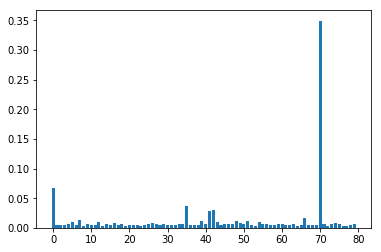

16.22


In [78]:
model.eval()
label = '01d2c640.wav'
label = '3f1ca1bb.wav'
img = preproc[label]
# img = valid_dataset.prep_img(valid_dataset.crop_img(valid_dataset.preprep_img(img)))
# out = torch.sigmoid(model(img.unsqueeze(0).cuda()))[0].data.cpu().numpy()

out = torch.mean(torch.stack([
    torch.sigmoid(model(valid_dataset.prep_img(valid_dataset.crop_img(valid_dataset.preprep_img(
        img))).unsqueeze(0).cuda()))[0] for i in range(30)], 0), 0).data.cpu().numpy()

print([labels[i] for i in reversed(out.argsort()[-5:])])
plt.bar(np.arange(80), out)
plt.show()

import IPython
from scipy.io.wavfile import read
fs_data_dir = Path(os.environ['FS_INPUTS_BASE']) / 'freesound-audio-tagging-2019/'
test_wavs_dir = fs_data_dir / 'test'
wavpath = str(test_wavs_dir / label)
wav = read(wavpath)[1]
print(wav.shape[0] / 44100)
IPython.display.Audio(wavpath)

array(['000ccb97.wav', '0012633b.wav', '001ed5f1.wav', ...,
       '4215309a.wav', '4248d196.wav', '42542036.wav'], dtype=object)

In [102]:
test_batch_size = 32
test_dataset = FATTrainDataset(preproc, x_test, None, seq=None, is_training=False, no_unlabeled=True, no_labels=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [108]:
def pred_test_set(model, test_loader, mb=None):
    model.eval()
    preds_all = None
    with torch.no_grad():
        for x_batch in progress_bar(test_loader, parent=mb):
            preds = torch.sigmoid(model(x_batch[0].cuda())).cpu()
            if preds_all is None:
                preds_all = preds
            else:
                preds_all = torch.cat([preds_all, preds], 0)
    return preds_all.numpy()

In [109]:
tta = 10
mb = master_bar(range(tta))
preds = None
for i in mb:
    if preds is None:
        preds = pred_test_set(test_loader, mb)
    else:
        preds += pred_test_set(test_loader, mb)

In [112]:
preds /= tta

In [115]:
df_sample[labels] = preds

In [126]:
df_sample.to_csv('submission.csv', index=False)